# Flight Data Analysis - Airbus

In [1]:
#!pip install lifelines

In [2]:
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

from scipy.stats import exponweib, lognorm
from scipy.stats import distributions

from numpy import arange, dot, exp, newaxis, pi, tensordot
from scipy.special import gamma, kv
from scipy.stats import rv_continuous
from scipy.stats import norm

import warnings

## I. Data Set

In [3]:
# import sys
# sys.path.append('/content/drive/My Drive/Hoc/Projet5A/')
# import vect
# from vect import varange, vectorize

# from google.colab import drive
# drive.mount('/content/drive/')
# file_location = '/content/drive/My Drive/Hoc/Projet5A/INSA-Airbus FHS - Dataset_ter.xlsx'

file_location = "./Dataset_ter.xlsx"

Removals = pd.read_excel(file_location, sheet_name='Removals')
SNlist = pd.read_excel(file_location, sheet_name='SN list')

In [4]:
Removals.info()
Removals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Customer                       2388 non-null   int64         
 1   Removal date                   2388 non-null   datetime64[ns]
 2   P/N                            2388 non-null   object        
 3   Description                    2388 non-null   object        
 4   S/N                            2388 non-null   object        
 5   Maintenance Type               2388 non-null   object        
 6   TSI (Flight Hours) at removal  2296 non-null   float64       
 7   TSN (Flight Hours) at Removal  2335 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 149.4+ KB


,Customer,Removal date,P/N,Description,S/N,Maintenance Type,TSI (Flight Hours) at removal,TSN (Flight Hours) at Removal
0,3,2015-01-01,C,PN_C,15323054356,Unscheduled,5819.0,5819.0
1,3,2015-01-01,C,PN_C,15323057041,Unscheduled,5819.0,5819.0
2,3,2015-01-03,C,PN_C,15323072973,Unscheduled,3036.0,3036.0
3,3,2015-01-07,C,PN_C,15323053425,Unscheduled,5614.0,5614.0
4,3,2015-01-07,C,PN_C,15323058236,Unscheduled,5614.0,5614.0


In [5]:
SNlist.info()
SNlist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Part Number                     5785 non-null   object 
 1   Description                     5785 non-null   object 
 2   Serial Number                   5785 non-null   object 
 3   Current SN Status Description   5785 non-null   object 
 4   Company                         5784 non-null   object 
 5   Hour ageing Since Installation  5745 non-null   float64
 6   Hour ageing Since New           5637 non-null   float64
 7   Since New Date                  4350 non-null   object 
dtypes: float64(2), object(6)
memory usage: 361.7+ KB


,Part Number,Description,Serial Number,Current SN Status Description,Company,Hour ageing Since Installation,Hour ageing Since New,Since New Date
0,A,PN_A,XXXM01-00324,On Aircraft,5,39498.39,54222.37,2007-11-19 00:00:00
1,A,PN_A,XXXM01-00329,On Aircraft,5,54525.41,54525.41,2007-11-19 00:00:00
2,A,PN_A,XXXM01-00334,On Aircraft,5,32238.92,52831.08,2008-03-12 00:00:00
3,A,PN_A,XXXM01-00337,On Aircraft,5,6951.19,52169.46,2006-04-01 00:00:00
4,A,PN_A,XXXM01-00338,On Aircraft,5,55511.55,55511.55,2008-03-12 00:00:00


##### Combining Removals and SNlist :

In [6]:
fail_and_not = SNlist.copy()
fail_and_not['failed'] = False
fail_and_not[fail_and_not['Current SN Status Description']=='In Outside Repair']=True
fail_and_not = fail_and_not.drop(['Description','Current SN Status Description','Since New Date'], axis = 1)
fail_and_not = fail_and_not.rename(columns={"Part Number": "PN", "Serial Number": "SN", "Hour ageing Since Installation": "TSI", "Hour ageing Since New": "TSN"})
#dic_PN = {"C":"C","C-new":"C","A":"A","B":"B"}
dic_PN = {"C":"C","C-new":"C-new","A":"A","B":"B"}
fail_and_not["PN"] = fail_and_not.PN.map(dic_PN)

fail = Removals[Removals['Maintenance Type']=='Unscheduled']
fail = fail.drop(['Removal date','Description','Maintenance Type'], axis=1)
fail = fail.rename(columns={"P/N": "PN", "S/N": "SN", "TSI (Flight Hours) at removal": "TSI", "TSN (Flight Hours) at Removal": "TSN", "Customer":"Company"})
fail['failed'] = True
fail['PN'] = fail.PN.map(dic_PN)

all_SN = pd.unique(fail_and_not['SN'])
SN_Removals = pd.unique(fail['SN'])

combined = pd.concat([fail,fail_and_not], ignore_index=True)
combined = combined.drop_duplicates(subset=['SN','PN','TSN'], keep='last')

##### Data errors treatment

In [7]:
combined['TSI']=combined['TSI'].replace(np.nan, 0.0)
combined['TSN']=combined['TSN'].replace(np.nan, 0.0)
combined['Company']=combined['Company'].replace('1', 1)
combined['Company']=combined['Company'].replace('3', 3)
combined = combined[combined['TSN']!=0]
types = pd.unique(combined["PN"])
types = types[np.logical_not(pd.isnull(types))]
print("Unit types :",types)
combined.head()

Unit types : ['C' 'B' 'A' 'C-new']


,Company,PN,SN,TSI,TSN,failed
0,3,C,15323054356,5819,5819,True
1,3,C,15323057041,5819,5819,True
2,3,C,15323072973,3036,3036,True
3,3,C,15323053425,5614,5614,True
4,3,C,15323058236,5614,5614,True


In [8]:
print(len(set(combined['SN'])),'/',len(combined), 'distinct number part.')

6005 / 7758 distinct number part.


## II. Data Analysis

In [9]:
data = combined.copy()
alpha = 0.05 # coefficient related to confidence levels

In [10]:
data_types = {}
for typ in types:
    data_types[typ] = data[data['PN']==typ]

In [11]:
def time_sticker(data_type): 
    T = data_type.TSI.to_numpy(dtype="float")
    d = np.array([1 if f == True else 0 for f in data_type.failed])
    return T,d

### 1. Nelson-Aalen and Kaplan-Meier estimators

We first consider the Nelson-Aalen estimator and the Kaplan-Meier estimator which will be used to compare with the model we apply for data in each cases.

(Note that we need to install the "lifelines" package for Python).

In [12]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

def NAF(typ,df=data_types): # Nelson_Aalen model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "NA-estimator of type " + typ
    return NelsonAalenFitter().fit(T,d,alpha=alpha,label=label)

def KMF(typ,df=data_types): # Kaplan_meier model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "KM-estimator of type " + typ
    return KaplanMeierFitter().fit(T,d,alpha=alpha,label=label)

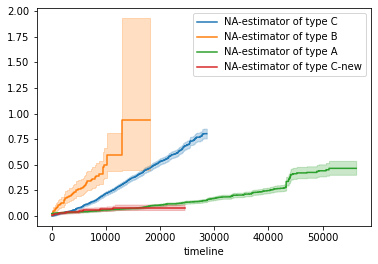

In [13]:
for typ in types:
    NAF(typ).plot(ci_show=True)

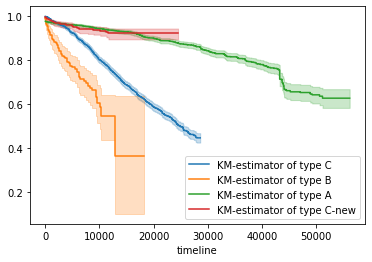

In [14]:
for typ in types:
    KMF(typ).plot(ci_show=True)

### 2. Parametric models

Find best parametric model

In [15]:
from lifelines.utils import find_best_parametric_model

def best_parametric_model(typ,df=data_types): # find the best parametric model which bases in AIC (or BIC as we can change scoring_method="BIC") method.
    data_type = df[typ]
    T,d=time_sticker(data_type)
    T[T==0]=1e-6 # Avoid divising by zero.
    tau=1-sum(d)/len(d)
    if tau>0.9:
        warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct! If the algorithms does not stop, please remove that part number.".format(str(typ)))
    best_model = find_best_parametric_model(T, d, scoring_method="AIC")[0]
    return best_model

Plotting best parametric model and KM-estimator:

In [16]:
def R_plot(typ): # We visualize if the best parametric model can fit the data of type "typ"
    m = best_parametric_model(typ)
    m.survival_function_.plot()
    KMF(typ).plot()
    plt.ylabel('Reliability function')
    plt.xlabel('Timeline')
    plt.title('Type ' + typ + ' data')

<ipython-input-15-787adfbe1e13>:9: UserWarning: There are more 90% censored data in type C-new data. The applied model might not be correct! If the algorithms does not stop, please remove that part number.
  warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct! If the algorithms does not stop, please remove that part number.".format(str(typ)))


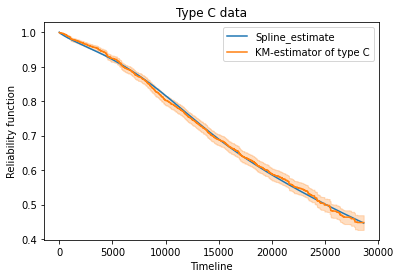

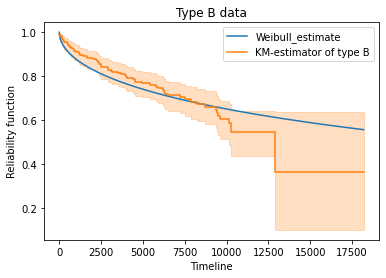

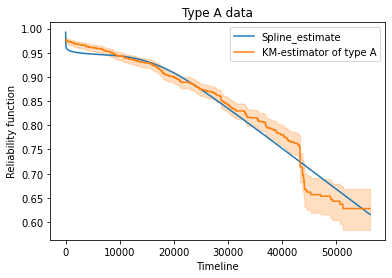

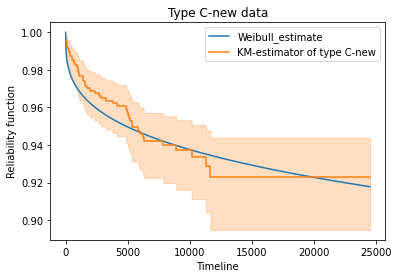

In [17]:
for typ in types:
    R_plot(typ)

## III. Simulation and stock optimization 

In [18]:
airlines = pd.read_excel(file_location, sheet_name='Airlines')
list_company = pd.unique(airlines["Company"])
list_company = list_company[np.logical_not(pd.isnull(list_company))]
print("List of companies :",list_company)
airlines

List of companies : [1 2 3 4 5 6]


,Company,Number of aircraft,FH per aircraft per month,End of contract
0,1,6,415,2024-12-01
1,2,2,310,2030-12-01
2,3,12,350,2026-12-01
3,4,5,240,2023-12-01
4,5,19,375,2026-12-01
5,6,6,350,2027-12-01


In [19]:
PN_table = pd.read_excel(file_location, sheet_name='PN')
PN_table

,Part Number,QPA,Unnamed: 2
0,A,60,NaN
1,B,4,NaN
2,C,224,Warning: 224 is the QPA of P/N C or P/N C-new
3,C-new,224,NaN


Simulation from parametric law

The idea is: for each individual SN, we simulate the number of time it will fail till the end of contract, then for large number of SN, we repeat that simulation for each individual to calculate the sum.

Simulation from kaplan Meier

In [20]:
def inverse_sampling(kapmei, timeline):
    u = np.random.uniform()
    if u < kapmei[-1]:
        T = -1
    elif u > kapmei[0]:
        T = 0
    else:
        arg = np.argmax(kapmei<=u)-1
        T = timeline[arg]+(timeline[arg+1]-timeline[arg])*(kapmei[arg]-u)/(kapmei[arg]-kapmei[arg+1])
    return T

def conditional_inverse_sampling(kapmei, timeline, TSI):
    T = 0
    while T<=TSI and T>=0:
        T = inverse_sampling(kapmei, timeline)
    return T

def num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline):    
    t = conditional_inverse_sampling(kapmei, timeline, TSI)
    if t <= T:
        n_fails = 0 
        sum_t = (t==-1)*np.max(timeline) + (t!=-1)*t
        while sum_t <= T:
            t = inverse_sampling(kapmei, timeline)
            sum_t += (t==-1)*np.max(timeline) + (t!=-1)*t
            n_fails += 1
        return n_fails
    else: 
        return 0

def num_of_fails_list(TSI_list, T, kapmei, timeline):
    n_fails_list = []
    for TSI in TSI_list:
        n_fails = num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline)
        n_fails_list += [n_fails]
    total_fails = np.sum(n_fails_list)
    return total_fails

Estimate stock:

In [28]:
import datetime as dt

def Estimated_Stock(company,typ,year,month,df=data,MC=200):
# MC is number iteration of Monte-Carlo
    survival = KMF(typ).survival_function_.to_numpy()
    timeline = KMF(typ).timeline
    
    FH_per_month = float(airlines[airlines['Company']==company]['FH per aircraft per month'])
    End = dt.datetime(year, month, 1)
    Today = dt.datetime.now()
    FH_till_end = FH_per_month*((End.year-Today.year)*12+End.month-Today.month)
    
    if FH_till_end>np.max(timeline):
        warnings.warn("Kaplan-Meier model of type {} data can not estimate the stock until that day. We apply the best parametric model to predict in this case.".format(str(typ)))
        survival = best_parametric_model(typ).survival_function_.to_numpy()
        timeline = best_parametric_model(typ).timeline

    dat = df[df.Company==company]
    dat = dat[dat.PN==typ]
    total = len(dat.TSI)
    num_not_failed = total-sum(dat.failed)
  
    list_TSI = dat[dat.failed==False].TSI

    stock = 0
    y=[]
    for i in range(MC):
        a = num_of_fails_list(list_TSI,FH_till_end,survival,timeline)
        y += [a]
        stock += a
    stock = stock/MC  
    return stock, (num_not_failed,total), y

Confidence Interval by Central Limit Theorem:

In [29]:
def CI(Y,alpha=alpha):
    n=len(Y)
    mu=np.mean(Y)
    std=np.std(Y)
    q=norm.ppf(1-alpha/2, loc=0, scale=1)
    S=std*q/np.sqrt(n)
    low=np.max([0.0,mu-S])
    high=mu+S
    return (low,high)

Visualize results:

In [30]:
def Result_display(company,unit_type,year,month,alpha=alpha):
    s,t,y = Estimated_Stock(company,unit_type,year,month)
    print("There are %d/%d units of type %s of company %d that is not failed at the moment."%(t[0],t[1],unit_type,company))
    print("Estimated number of type %s unit in stock for company %d until %d/%d:"%(unit_type,company,month,year), s)
    ci=CI(y) #Confidence interval
    print("with confidence interval (%f,%f) at level %0.2f"%(ci[0],ci[1],100-100*alpha), end="")
    print("%.")
    plt.hist(y, bins = np.arange(int(np.min(y)-1),int(np.max(y)+1),1))
    plt.ylabel('Frequency')
    plt.xlabel('Estimated number')
    plt.show()
    y_sum = np.cumsum(y)
    moyen = y_sum/np.arange(1, len(y)+1,1)
    plt.plot(moyen)
    plt.ylabel('Estimated number')
    plt.xlabel('Monte-Carlo iteration')
    plt.show()

There are 361/377 units of type A of company 1 that is not failed at the moment.
Estimated number of type A unit in stock for company 1 until 6/2030: 98.295
with confidence interval (97.107256,99.482744) at level 95.00%.


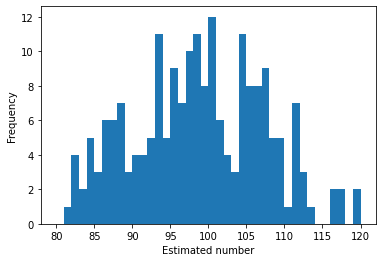

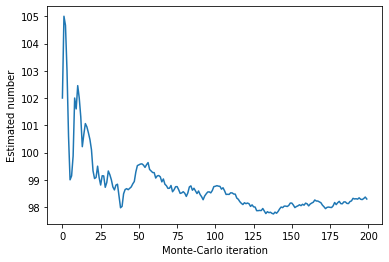

In [31]:
company=1         #INTEGER
unit_type='A' #STRING
year=2030         #INTEGER
month=6           #INTEGER

Result_display(company,unit_type,year,month)

<ipython-input-28-4c45b32947cd>:14: UserWarning: Kaplan-Meier model of type B data can not estimate the stock until that day. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of type {} data can not estimate the stock until that day. We apply the best parametric model to predict in this case.".format(str(typ)))


There are 39/43 units of type B of company 3 that is not failed at the moment.
Estimated number of type B unit in stock for company 3 until 6/2030: 106.105
with confidence interval (105.322192,106.887808) at level 95.00%.


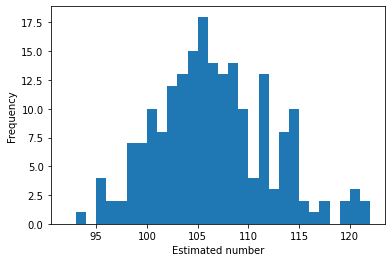

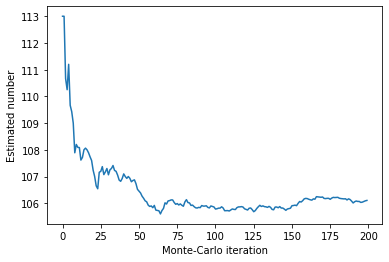

In [32]:
company=3         #INTEGER
unit_type='B' #STRING
year=2030         #INTEGER
month=6           #INTEGER

Result_display(company,unit_type,year,month)

Test model using Kolmogorov-Smirnov, Kramer-von Mise

In [26]:
# def weib_R(x, alpha, beta):
#     return np.exp(-np.power(x/alpha, beta))

# def expo_R(x, lamb):
#     return np.exp(-1/lamb*x)

# def lognor_R(x, mu, std):
#     return 1-lognorm.cdf(x,std)

# def KStest(kap_meier, R, **args):
#     x1 = kap_meier.timeline
#     y1 = kap_meier.survival_function_.to_numpy().reshape((len(x1)))
#     y2 = R(x1, **args)
#     stat = np.max(np.abs(y1-y2))
#     prob = distributions.kstwobign.sf(stat*np.sqrt(len(x1)))
#     return stat, prob

# class cvm_unif_gen(rv_continuous):
#     def _argcheck(self, samples):
#         return samples > 0

#     @vectorize(otypes=(float,))
#     def _cdf(self, statistic, samples):
#         low = 1 / (12 * samples)
#         # Basic bounds.
#         if statistic <= low:
#             return 0.
#         if statistic >= samples / 3:
#             return 1.
#         # From the geometric approach of Csorgo and Faraway.
#         if statistic <= low + 1 / (4 * samples ** 2):
#             return (gamma(samples + 1) / gamma(samples / 2 + 1) *
#                                     (pi * (statistic - low)) ** (samples / 2))
#         # Asymptotic distribution with a one-term correction.
#         return cvm_unif_inf(statistic) + cvm_unif_fix1(statistic) / samples


# cvm_unif = cvm_unif_gen(a=0, name='cvm-unif', shapes='samples')

# inf_ks41 = 4 * arange(11) + 1
# inf_args = inf_ks41 ** 2 / 16
# inf_cs = (inf_ks41 ** .5 * gamma(varange(.5, 11)) /
#                                         (pi ** 1.5 * gamma(varange(1, 11))))


# def cvm_unif_inf(statistic):
#     """
#     Calculates the limiting distribution of the Cramer-von Mises statistic.

#     After the second line of equation 1.3 from the Csorgo and Faraway paper.
#     """
#     args = inf_args / statistic
#     return (inf_cs * exp(-args) * kv(.25, args)).sum() / statistic ** .5

# fix1_args = (4 * (varange((.5, 1., 1.5), 21)) - 1) ** 2 / 16
# fix1_dens = 72 * pi ** 1.5 * gamma(varange(1, 21))
# fix1_csa = fix1_args ** .75 * gamma(varange(1.5, 21)) / fix1_dens
# fix1_csb = fix1_args ** 1.25 * gamma(varange((.5, 1.5, 2.5), 21)) / fix1_dens


# def cvm_unif_fix1(statistic):
#     """
#     Approximates the first-term of the small sample count Gotze expansion.

#     After equation 1.10 (with coefficients pulled out as csa / csb).
#     """
#     args = fix1_args / statistic
#     kvs = kv((.25, .75, 1.25), args[:, :, newaxis])
#     gs, hs = exp(-args) * tensordot(((1, 1, 0), (2, 3, -1)), kvs, axes=(1, 2))
#     a = dot((7, 16, 7), fix1_csa * gs).sum() / statistic ** 1.5
#     b = dot((1, 0, 24), fix1_csb * hs).sum() / statistic ** 2.5
#     return cvm_unif_inf(statistic) / 12 - a - b
    
# def CVMtest(kap_meier, R, **args):
#     x1 = kap_meier.timeline
#     n = len(x1)
#     y1 = kap_meier.survival_function_.to_numpy().reshape((n))
#     y2 = np.linspace(1, np.min(y1), n)
#     y3 = R(x1, **args)

#     stat = 1/(12*n) + ((y3-y2)**2).sum()
#     p_valeur = cvm_unif(n).sf(stat)
#     return stat, p_valeur

In [27]:
# # exponential
# T = 10 # time T : end of contract
# lamb = models('B')[dict_model['Exponential']].lambda_ # parameter of exponential distribution
# SN_sim = combined[combined["PN"]=="B"]
# print(len(np.unique(SN_sim["SN"])))

# rand_draw_func = np.random.exponential

# def num_of_fails_indivi(TSI, T, rand_draw_func, **args):
#     n_fails = -1 # once the algo enter the loop, n_fails is at least 1
#     sum_t = 0
#     while sum_t <= T:
#         t = rand_draw_func(**args)
#         sum_t += t
#         n_fails += 1
#     return n_fails

# def num_of_fails_list(TSI_list, T, rand_draw_func, **args):
#     n_fails_list = []
#     for TSI in TSI_list:
#         n_fails = num_of_fails_indivi(TSI, T, rand_draw_func, **args)
#         n_fails_list += [n_fails]
#     total_fails = np.sum(n_fails_list)
#     return total_fails


